# Дерева для класифікації та регресії (CART)

&emsp;&emsp;Ідея регресійного дерева схожа за принципом з алгоритмом $k$-середніх: потрібно зробити таке розбиття простору на кластери, щоб дисперсія відстаней точок до центрів своїх кластерів була меншою, ніж дисперсія відстаней до глобального центру. Однак робиться це дещо іншим способом:

&emsp;&emsp;1. На першому кроці беремо одну змінну з наших даних та розбиваємо її на рівні інтервали. Скажімо, якщо змінна набуває значення від 0 до 100, то можна взяти як межі інтервалів значення 10, 20, 30 і т.д.

&emsp;&emsp;2. Ділимо дані на 2 групи: одна більше поточного значення змінної (більше 20, наприклад), а інша - менше, і обчислюємо як сильно знизиться дисперсія відстаней всередині отриманих груп, порівняно із загальною дисперсією.

&emsp;&emsp;3. Проходимося таким чином по всіх змінних та по всіх запропонованих точках розбиття. Фінально вибираємо змінну та точку, розбиття якою дасть максимальне зниження дисперсії.

&emsp;&emsp;4. Отримавши на попередньому кроці 2 групи, повторюємо цей процес у кожній з нихх окремо до того часу, поки кількість розбиття не досягне наперед заданого числа.

&emsp;&emsp;Весь процес нагадує розгалуження дерева (звідси і назва), точки розбиття називаються вузлами, а останні отримані групи даних називаються листям дерева.

&emsp;&emsp;Розглянемо приклад побудови дерева для завдання оцінки вартості нерухомості:

In [19]:
import pandas as pd
data = pd.read_csv('RealEstate.csv', sep=',', header=0)

X = data[['X2 house age', 'X3 distance to the nearest MRT station',
          'X4 number of convenience stores', 'X1 transaction date']]

y = data['Y house price of unit area'].values

In [21]:
from sklearn.tree import DecisionTreeRegressor

tre = DecisionTreeRegressor(
    criterion='squared_error',  # критерій розбивки – зменшення середньоквадратичної помилки
    max_depth=2,  # максимальна кількість розбиттів (глибина дерева)
    min_samples_split=10,  # мінімальна кількість спостережень, щоб зробити розбиття
    min_samples_leaf=5  # мінімальна кількість спостережень, щоб сформувати лист дерева
).fit(X, y)

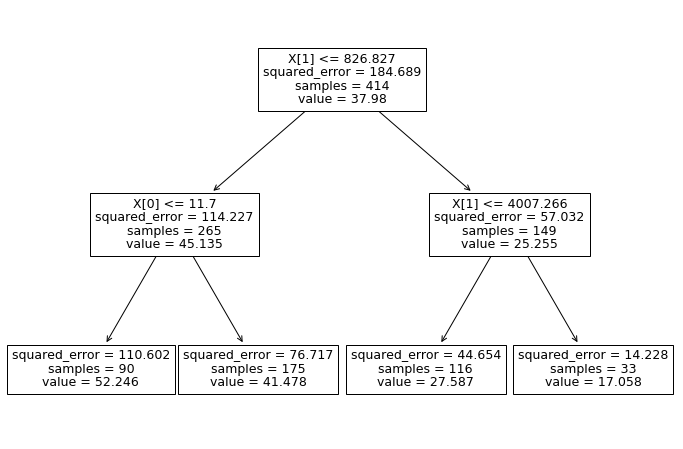

In [22]:
from sklearn.tree import plot_tree 
from matplotlib import pyplot as plt

plt.figure(figsize=(12,8))
plot_tree(tre)
plt.show()

In [25]:
len(X), y.mean()

(414, 37.980193236714975)

In [4]:
y[X['X3 distance to the nearest MRT station']<=826.827].mean()

45.13509433962265

&emsp;&emsp;Ми можемо скористатися тією ж процедурою для класифікації практично без змін, потрібно лише замінити критерій розгалуження.

&emsp;&emsp;За аналогією з регресійним деревом, ми хочемо отримати найбільш однорідне листя. Наприклад, якщо в даних присутні 3 класи, то нам слід віддати перевагу аркуш з розподілом [0.95, 0.025, 0.025] перед аркушем з розподілом [0.3, 0.4, 0.3]. Другий лист можна також назвати більш непередбачуваним, оскільки класи в ньому зустрічаються практично рівноймовірно.

&emsp;&emsp;Популярною мірою непередбачуваності є ентропія - величина, яка описує чисельно "непередбачуваність" випадкової величини:

$$Entropy = -\sum_{i=1}^{n}{p_{i}log(p_{i})},$$

&emsp;&emsp; де $p_{i}$ - ймовірністьь $i$-го класса, $n$ - кількість класів.

&emsp;&emsp;Розглянемо приклад із підкиданням монетки. У такому експерименті є всього 2 можливі результати, ймовірність випадання герба = $p$, а цифри рівна $(1-p)$. Тоді формула ентропії зведеться до наступного:

$$CoinEntropy = -plog(p) - (1 - p)log(1-p)$$

&emsp;&emsp;Побудуємо графік залежності ентропії від різних значень $p$:

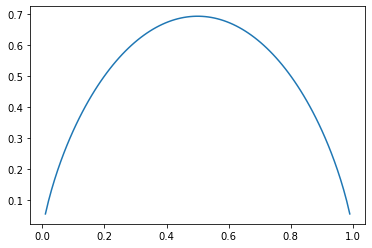

In [26]:
import numpy as np
from matplotlib import pyplot as plt

p = np.linspace(0.01, 0.99, 100)  # створимо набір із різних значень ймовірності р
coin_entropy = -p * np.log(p) - (1 - p) * np.log(1 - p)  # обчислимо ентропію для кожного з них

plt.plot(p, coin_entropy)
plt.show()

&emsp;&emsp;Як бачимо, максимального значення ентропія досягає при ймовірності $р = 0.5$, тому що в цьому випадку результат максимально непередбачуваний. В околі значень близьких до 0 або 1 ентропія близька до 0, оскільки результат є досить очевидним.

&emsp;&emsp;Інший дуже популярною мірою однорідності, схожою з ентропією, є індекс Джині, який обчислюється як:

$$Gini = 1 - \sum_{i=1}^{n}{p_{i}^{2}},$$

&emsp;&emsp;де $p_{i}$ - ймовірність $i$-го класу, $n$ - кількість класів.

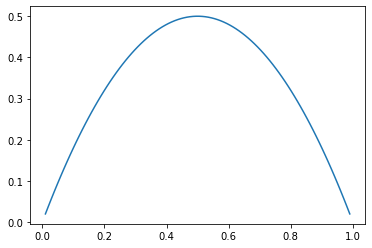

In [27]:
import numpy as np
from matplotlib import pyplot as plt

p = np.linspace(0.01, 0.99, 100)  # створимо набір із різних значень ймовірності р
coin_gini = 1 - p ** 2 - (1 - p) ** 2  # обчислимо ентропію для кожного з них

plt.plot(p, coin_gini)
plt.show()

&emsp;&emsp;Розглянемо приклад класифікації на даних про види ірисів:

1.0


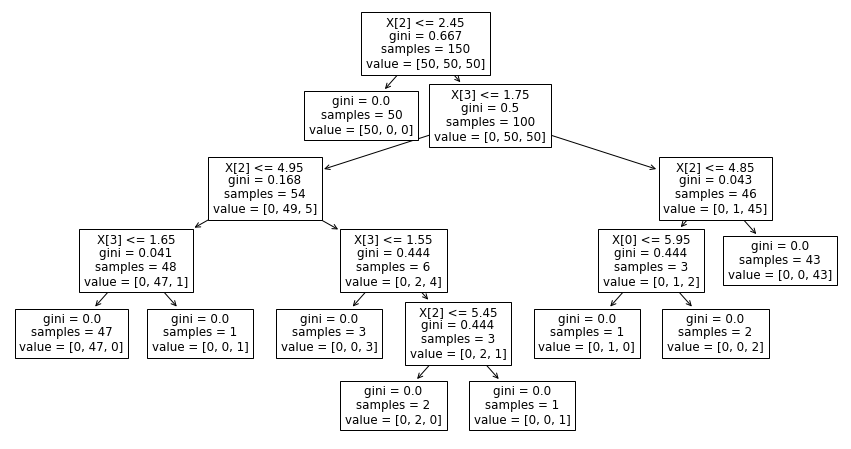

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import roc_auc_score

X, y = load_iris(return_X_y=True)
tre = DecisionTreeClassifier(max_depth=5).fit(X, y)

predictions = tre.predict_proba(X)
auc = roc_auc_score(y, predictions, average='macro', multi_class='ovr')

print(auc)

plt.figure(figsize=(15,8))
plot_tree(tre)
plt.show()

In [43]:
tre.predict([[1, 2, 0.2, 0.7]])

array([0])

# Bagging

&emsp;&emsp;Проілюструємо ідею бегінга на прикладі ірисів. Розіб'ємо дані на навчальну та тестову групу, як завжди, і побудуємо дерево для класифікації.

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# вивантажимо дані
iris = load_iris()
X, y = iris.data[:, :2], iris.target

# зробимо розбивку на навчальну та тестову групи
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# будуємо модель у вигляді дерева
mdl = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)

# оцінимо якість моделі
predictions = mdl.predict_proba(X_test)
auc = roc_auc_score(y_test, predictions, average='macro', multi_class='ovr')
print(auc)

0.9114997088681299


&emsp;&emsp;Ми отримали AUC на рівні 0.91, скориставшись при цьому всіма даними навчального набору. Однак, що було б, якби наш навчальний набір був меншим, скажімо, 80% від поточного? Побудуємо кілька моделей використовуючи лише 80% випадково вибраних даних з навчального набору та порівняємо їх якість:

In [58]:
num_models = 15  # визначимо кількість моделей, яку ми хочемо побудувати
all_predictions = np.zeros((len(y_test), 3), dtype=np.float32)  # масив, до якого ми додаватимемо прогнози
for i in range(num_models):    
    np.random.seed(i)  # зафіксуємо випадковий стан
    
    # отримаємо вибірку з навчального набору розміром 80%
    sub_train_idx = np.random.choice(np.arange(len(X_train)), size=int(0.8 * len(X_train)), replace=False)
    X_sub_train, y_sub_train = X_train[sub_train_idx], y_train[sub_train_idx]
    
    mdl = DecisionTreeClassifier(max_depth=3).fit(X_sub_train, y_sub_train)  # навчимо модель
    
    # виведемо результат
    print(f'AUC score модели {i}: ', roc_auc_score(y_test, mdl.predict_proba(X_test),
                                                   average='macro', multi_class='ovr'))
    
    all_predictions += mdl.predict_proba(X_test)  # додамо прогноз поточної моделі до масиву прогнозів

AUC score модели 0:  0.8169573766064996
AUC score модели 1:  0.8669245715298347
AUC score модели 2:  0.9114997088681299
AUC score модели 3:  0.8954199471743332
AUC score модели 4:  0.877863724968988
AUC score модели 5:  0.8321979190400244
AUC score модели 6:  0.9114153228188316
AUC score модели 7:  0.9062087035771246
AUC score модели 8:  0.8321979190400244
AUC score модели 9:  0.8834535834535835
AUC score модели 10:  0.8293790030632135
AUC score модели 11:  0.9274950845126284
AUC score модели 12:  0.8518894036437897
AUC score модели 13:  0.8494924179134706
AUC score модели 14:  0.8321979190400244


&emsp;&emsp;А тепер подивимося, який результат ми отримаємо, якщо порахуємо середні прогнози всіх наших моделей:

In [10]:
avg_predictions = all_predictions / num_models
print(roc_auc_score(y_test, avg_predictions, average='macro', multi_class='ovr'))

0.9389318624844941


&emsp;&emsp;Ми отримали результат навіть краще, ніж під час використання всіх навчальних даних!

&emsp;&emsp;Основна ідея бегінга полягає в тому, щоб побудувати кілька однакових моделей на випадковій вибірці даних, а потім усереднити їх прогнози. Дані можуть повторюватися у різних моделях.

&emsp;&emsp;Поліпшення відбувається за рахунок того, що моделі більш-менш незалежні одина від одної, оскільки навчалися на неоднакових даних. Крім того, можна було піти далі і навчатись на трохи різних наборах змінних, скажімо, робити ще й вибірку у 80% від усіх доступних змінних. Фінально, знайшовши середнє значення прогнозів моделей, помилка однієї може бути компенсована більш вдалим здогадом іншої, що призводить до більш стабільних і часто більш точних результатів.

&emsp;&emsp;Процедура бегінга загальна і може використовуватися з будь-яким алгоритмом. Якщо ж вона використовується у зв'язці з регресійним або класифікаційним деревом, як ми зробили вище, такий підхід називають Random Forest. Розглянемо приклад із готовим класом:

In [66]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier(
    n_estimators = 80, # кількість дерев, які потрібно побудувати
    criterion='gini', # критерій побудови: підвищення однорідності у листі дерева
    max_depth=3, # максимальна глибина дерева
    min_samples_split=10, # мінімальна кількість спостережень, щоб зробити розбивку даних на 2 підгрупи
    min_samples_leaf=5, # мінімальна кількість спостережень, яка може сформувати лист дерева
    max_features=0.8, # максимальна кількість змінних, якими можна скористатися в одному дереві
    bootstrap=True, # чи будувати кожне дерево на вибірці з оригінальних даних
    max_samples=0.8, # частка даних, яка може бути використана в побудові одного дерева
    random_state=42 # фіксація випадкового стану
)

mdl = mdl.fit(X_train, y_train)  # навчання моделі

# оцінка якості моделі на тестових даних
auc = roc_auc_score(y_test, mdl.predict_proba(X_test), average='macro', multi_class='ovr')

print(auc)

0.9411407306144147


# Boosting

&emsp;&emsp;Ідея бустингу схожа з ідеєю бегінга в тому, що одна модель складається з безлічі однакових моделей, кожна з яких дає невисоку точність сама по собі, проте колективно дозволяють вийти на досить високий результат. Такий підхід загалом називається ансамблем.

&emsp;&emsp;Однак, якщо у бегінгу всі моделі будувалися абсолютно незалежно одна від одної (на дещо різних даних, щоб різні учасники ансамблю не були абсолютно однаковими), то в бустингу ідея інша: кожна наступна модель будується таким чином, щоб скоригувати помилку всіх попередніх моделей. Незважаючи на те, що бустинг, як і бегінг, можуть бути побудовані у зв'язці з будь-яким алгоритмом, найбільшої популярності набув бустинг у зв'язці з деревами класифікації та регресії, на прикладі яких ми й розбиратимемо весь процес.

&emsp;&emsp;Варто відразу сказати, що існує кілька варіантів бустингу, кожен з яких по-своєму трактує поняття помилки. Найуніверсальнішим і найпоширенішим варіантом (який і розбиратимемо) є градієнтний бустинг, який дозволяє оптимізувати будь-яку диференційовну функцію втрат.

&emsp;&emsp;Для завдання регресії визначимо прогноз нашої бустинг моделі таким чином:

$$\hat{y_{i}} = \phi(x_{i}) = \sum_{k=1}^{K}{f_{k}(x_{i})}$$

&emsp;&emsp;Тут $f_{k}(x_{i})$ - деяка функція, яка застосовується до спостереження $x_{i}$.
Коли ми робили модель за принципом бегінга, то такою функцією було регресійне дерево або
якась інша модель, навчена на підмножині даних. Поки все залишається так само за тим
винятком, що ми не усереднюємо прогнози наших моделей, а лише підсумовуємо.

&emsp;&emsp;Якщо $f_{k}$ - регресійне дерево, то формально ми можемо визначити $f(x) =
w_{q(x)}$, де $w$ - деяке число, яке асоціюється з листом дерева. Маючи конкретне
спостереження $x$ ми спускаємося по дереву і, залежно від умов у кожному вузлі, вибираємо той
лист $q$, у який потрапляє наш $x$.

&emsp;&emsp;Нехай для нашого завдання є деяка функція втрат $l$, тоді загальну помилку
прогнозу можна записати як

$$L = \sum_{i=1}^{n}{l(y_{i}, y_{i}^{predicted})}$$

&emsp;&emsp;Конкретне значення функції $l$ визначається завданням. Якщо у нас завдання регресії,
то це може бути квадрат відхилення фактичного значення $y_{i}$ від прогнозного
$y_{i}^{predicted}$. Тоді функція втрат перепишеться як $L = \sum_{i=1}^{n}{
(y_{i} - \hat{y_{i}})^{2}}$

&emsp;&emsp;Одразу перейдемо до більш загальної форми функції втрат, а саме, якщо є
регуляризація моделі. Зазвичай для дерева можна запропонувати 2 наступні популярні форми
регуляризації:

&emsp;&emsp;1. $\gamma T$, де $T$ - кількість лисів дерева. Це обмеження на складність
дерева: чим менша глибина дерева і менше листя, то менше шансів перенавчання. Без
цього обмеження можна побудувати дерево, у кожному листі якого буде по одному
спостереженню, що дасть ідеальну точність під час навчання, проте така модель не буде мати користі для прогнозів.

&emsp;&emsp;2. $\frac{1}{2} \lambda \sum_{i=1}^{T}{w_{i}^2}$ - стандартна ridge регуляризація, яка накладається на значення у листах дерева.

&emsp;&emsp;Визначимо загальну регуляризацію для одного дерева як $\Omega(f) = \gamma T +
\frac{1}{2} \lambda \sum_{i=1}^{T}{w_{i}^2}$. Оскільки сумарно у нас у моделі буде $k$ дерев, то
загальна функція втрат запишеться як

$$L = \sum_{i=1}^{n}{l(y_{i}, \hat{y_{i}})} + \sum_{k=1}^{K}{\Omega(f_{k})}$$

&emsp;&emsp;Процес навчання дерев відбувається таким чином: спочатку будується одне дерево, що дає базовий прогноз, потім наступне, результат якого додається до результату попереднього і т.д. Розглянемо значення функції втрат у тому кроці, коли ми додаємо до моделі дерево $t$

$$L^{(t)} = \sum_{i=1}^{n}{l(y_{i}, \hat{y_{i}}^{(t-1)} + f_{t}(x_{i}))} + \Omega (f_{t})$$

&emsp;&emsp;Іншими словами, маючи $t-1$ дерев у моделі, наше завдання додати дерево $t$
таким чином, щоб максимально зменшити загальну помилку.

&emsp;&emsp;Диференційовану функцію $f(x)$ в околі деякої точки $a$ можна приблизно подати як $f(x) \approx f(a) + f^{'}(a)h + \frac{1}{2} f^{''}(a)h^{2}$, 
де $h=x - a$. 
Скористаємося цією властивістю, щоб переписати нашу функцію втрат так:

$$l(y_{i}, \hat{y_{i}}^{(t-1)} + f_{t}(x_{i})) \approx l(y_{i}, \hat{y_{i}}^{t-1}) + g_{i}f_{t}(x_{i}) + \frac{1}{2}h_{i}f_{t}^{2}(x_{i})$$

$$g_{i} = \frac{dl(y_{i}, \hat{y_{i}}^{t-1})}{d\hat{y_{i}}^{t-1}}, h_{i} = \frac{dg_{i}}{d\hat{y_{i}}^{t-1}}$$
&emsp;&emsp;Враховуючи, що $l(y_{i}, \hat{y_{i}}^{(t-1)})$ - це константа, яка залежить від дерев, побудованих на попередніх кроках, яка не впливає на поточне дерево, можемо записати функцію втрат наступним чином:

$$L^{(t)} = \sum_{i=1}^{n}{[g_{i}f_{t}(x_{i}) + \frac{1}{2}h_{i}f_{t}^{2}(x_{i})]} + \Omega(f_{t})$$

&emsp;&emsp;Определим множество $I_{j} = \{i|q(x_{i})=j\}$ - множество всех индексов наблюдений,
которые после прохода по дереву попадают в лист с индексом j. Вспоминая, что для листа j 
значение функции $f_{t}(x_{i}) = w_{j}$ можем переписать наше уравнение следующим образом:

$$L^{(t)} = \sum_{i=1}^{n}{[g_{i}f_{t}(x_{i}) + \frac{1}{2} h_{i}f_{t}^{2}(x_{i})]} + \gamma T + \frac{1}{2} \lambda \sum_{j=1}^{T}{w_{j}^{2}}=$$

$$=\sum_{j=1}^{T}{[(\sum_{i \in I_{j}}{g_{i}})w_{j} + \frac{1}{2}(\sum_{i \in I_{j}}{h_{i}} + \lambda)w_{j}^{2}]} + \gamma T$$

&emsp;&emsp;Взявши похідну $w_{j}$ і прирівнявши до 0 можемо знайти оптимальне значення $w_{j}$ для даного дерева:

$$w_{j}^{*} = -\frac{\sum_{i \in I_{j}}{g_{i}}}{\sum_{i \in I_{j}}{h_{i}} + \lambda}$$

&emsp;&emsp;Підставимо оптимальне значення $w_{j}$ у функцію втрат і отримаємо відповідне
мінімальне значення:

$$L^{(t)} = -\frac{1}{2} \sum_{j=1}^{T}{\frac{(\sum_{i \in I_{j}}{g_{i}})^{2}}{\sum_{i \in I_{j}}{h_{i}} + \lambda}} + \gamma T$$

&emsp;&emsp;Останньою формулою можна використовувати для оцінки дерева, яке ми додаємо до ансамблю. Потрібно віддавати перевагу тому дереву, яке відповідає мінімальному значенню запропонованої функції. Однак, на практиці розглянути всі можливі варіанти дерев немає можливості через занадто велику кількість комбінацій можливих розбиттів. Тому дерево будується в "жадібному" стилі таким чином:

&emsp;&emsp;1. Вибираємо деяку змінну з набору і розбиваємо наші дані на 2 групи. У першу групу потрапляють усі спостереження, які менші за якесь значення (назвемо цю групу $I_{L}$), а до другої - всі інші ($I_{R}$). Множину усіх спостережень будемо називати просто $I$

&emsp;&emsp;2. Порівнюємо, наскільки знизиться значення функції втрат за такого розбиття:

$$L_{split} = \Big[\frac{(\sum_{i \in I_{L}}{g_{i}})^{2}}{\sum_{i \in I_{L}}{h_{i}} + \lambda} + \frac{(\sum_{i \in I_{R}}{g_{i}})^{2}}{\sum_{i \in I_{R}}{h_{i}} + \lambda} - \frac{(\sum_{i \in I}{g_{i}})^{2}}{\sum_{i \in I}{h_{i}} + \lambda}\Big] - \gamma$$

&emsp;&emsp;3. Пройшовшись таким чином по всіх змінних і різних значеннях, для яких робиться розбивка, вибираємо краще, після чого повторюємо процес для створених підгруп.

&emsp;&emsp;Розглянемо приклад побудови моделі з даними про кредитне шахрайство

In [67]:
# pip install xgboost

In [68]:
import xgboost as xgb

# прочитаємо дані з файлу
data = pd.read_csv('fraud_detection.csv', sep=';', header=0)

# позбудемося змінної, якою не користуватимемося
data.drop('Time', inplace=True, axis=1)

# розіб'ємо дані на навчальну та тестову групу
X, y = data[[col for col in data.columns if col != 'Class']], data['Class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [69]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-0.304555,1.428078,-0.465237,1.118875,0.232754,-0.393477,0.303350,0.227604,-0.603336,-0.319304,...,0.076404,-0.169594,-0.556685,0.202056,0.654389,-1.025867,0.507719,-0.193612,0.168636,9.99
1,2.039281,-1.136313,-0.494459,-0.706625,-1.275460,-0.844796,-0.869408,-0.200329,0.071643,0.701772,...,0.120058,0.366399,1.023254,0.076369,0.097928,-0.162278,-0.098462,0.001007,-0.035839,76.00
2,-0.440527,0.474834,1.267986,-0.770614,0.100411,0.103569,0.156056,0.262048,0.658102,-0.588134,...,0.017168,0.161754,0.615951,-0.189338,0.495619,-0.305795,0.539162,0.355015,0.222507,11.50
3,-0.138435,-0.254154,0.870679,-2.773700,-0.120292,-0.278596,0.042839,-0.181491,-2.439011,0.638226,...,-0.193196,-0.114847,0.123163,-0.226453,0.497044,0.122834,-0.174314,0.118516,0.129059,15.00
4,1.460520,-1.318757,0.076848,0.676911,-1.384318,-0.110706,-0.729476,0.034545,1.663378,-0.324280,...,0.328152,0.401319,0.856349,-0.026830,-0.045067,-0.438057,-0.290342,0.033617,0.020524,255.46


In [74]:
# xgboost працює зі своїм вбудованим представленням даних - DMatrix, яка створюється таким чином:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# наступний крок - визначити словник з гіперпараметрами алгоритму
params = {
    'objective': 'binary:logistic', # цільова функція, яку ми мінімізуватимемо
    'learning_rate': 0.1, # параметр швидкості навчання
    'subsample': 0.8, # частка спостережень, яка буде використана у кожному дереві
    'colsample_bytree': 0.8, # частка змінних, яка буде використана в кожному дереві
    'colsample_bylevel': 0.8, # частка змінних, яка буде використана при кожному розбитті
    'lambda': 0.5, # параметр L2 регуляризації
    'gamma': 1., # параметр регуляризації, який накладає обмеження на розмір дерева
    'max_depth': 6, # максимальна глибина кожного дерева
    'min_child_weight': 5, # параметр, що визначає мінімальний розмір листа
    'eval_metric': 'auc', # метрика якості моделі
    'silent': 1, # чи виводити проміжні обчислення на екран
    'seed': 32 # фіксація випадкового стану
}

mdl = xgb.train(
    params=params, # словник з набором параметрів моделі
    dtrain = dtrain, # матриця з навчальними даними
    num_boost_round=50, # кількість дерев, які потрібно побудувати
    evals=[(dtrain, 'Train'), (dtest, 'Test')] # навчальні та тестові дані для оцінки якості
)


[20:47:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Train-auc:0.94229	Test-auc:0.91817
[1]	Train-auc:0.95558	Test-auc:0.95058
[2]	Train-auc:0.95715	Test-auc:0.95475
[3]	Train-auc:0.96352	Test-auc:0.95855
[4]	Train-auc:0.97032	Test-auc:0.95857
[5]	Train-auc:0.97397	Test-auc:0.97181
[6]	Train-auc:0.97626	Test-auc:0.97145
[7]	Train-auc:0.97642	Test-auc:0.97090
[8]	Train-auc:0.97606	Test-auc:0.97033
[9]	Train-auc:0.98034	Test-auc:0.96824
[10]	Train-auc:0.98063	Test-auc:0.96811
[11]	Train-auc:0.98051	Test-auc:0.96869
[12]	Train-auc:0.98062	Test-auc:0.96916
[13]	Train-auc:0.98046	Test-auc:0.96970
[14]	Train-auc:0.98175	Test-auc:0.9

&emsp;&emsp;Можливо, найважливішим параметром усієї моделі є кількість дерев. Якщо взяти їх дуже мало, то модель залишиться недонавченою, а якщо багато, то високий ризик перенавчання. На практиці застосовують техніку ранньої зупинки: ми продовжуємо додавати нові дерева до ансамблю, поки помилка на тестовому наборі не почне збільшуватися (ознака того, що ми досягли моменту перенавчання). Однак іноді трапляються стрибки в метриці якості: точність може трохи погіршитись, а на наступному дереві знову покращатися. Тому правило трохи послаблюють до наступної форми: продовжуємо додавати нові дерева доти, доки помилка на тестовому наборі не погіршується протягом $n$ ітерацій поспіль (на практиці беруть 10-20 ітерацій).

In [75]:
mdl = xgb.train(
    params=params,
    dtrain=dtrain, 
    num_boost_round=500, # візьмемо свідомо перебільшену кількість дерев 
    early_stopping_rounds=20, # кількість кроків з погіршенням метрики на тесті, після якого припиняємо навчання
    evals=[(dtrain, 'Train'), (dtest, 'Test')]
)

[20:50:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Train-auc:0.94229	Test-auc:0.91817
[1]	Train-auc:0.95558	Test-auc:0.95058
[2]	Train-auc:0.95715	Test-auc:0.95475
[3]	Train-auc:0.96352	Test-auc:0.95855
[4]	Train-auc:0.97032	Test-auc:0.95857
[5]	Train-auc:0.97397	Test-auc:0.97181
[6]	Train-auc:0.97626	Test-auc:0.97145
[7]	Train-auc:0.97642	Test-auc:0.97090
[8]	Train-auc:0.97606	Test-auc:0.97033
[9]	Train-auc:0.98034	Test-auc:0.96824
[10]	Train-auc:0.98063	Test-auc:0.96811
[11]	Train-auc:0.98051	Test-auc:0.96869
[12]	Train-auc:0.98062	Test-auc:0.96916
[13]	Train-auc:0.98046	Test-auc:0.96970
[14]	Train-auc:0.98175	Test-auc:0.9

&emsp;&emsp;Щоб не покладатися на один тестовий набір, можна скористатися крос-валідацією:

In [76]:
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    early_stopping_rounds=20,
    nfold=4, # кількість розбивок для крос-валідації 
    verbose_eval=True # чи виводити на екран проміжні результати
)

[20:53:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:53:20] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:53:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

&emsp;&emsp;Вибір оптимального набору гіперпараметрів прийнято проводити на крос-валідації

In [77]:
from sklearn.model_selection import GridSearchCV

# задаємо початковий набір параметрів включаючи кількість дерев
params = {
    'objective': 'binary:logistic', 
    'learning_rate': 0.1, 
    'subsample': 0.8, 
    'colsample_bytree': 0.8,
    'colsample_bylevel': 0.8, 
    'reg_lambda': 0.5, 
    'gamma': 1., 
    'max_depth': 6, 
    'min_child_weight': 5,
    'eval_metric': 'auc', 
    'silent': 1, 
    'seed': 32, 
    'n_estimators': 30
}

# щоб мати можливість використовувати GridSearchCV зі sklearn модель потрібно визначити як XGBClassifier
xgb_mdl = xgb.XGBClassifier(**params)

# задаємо сітку можливих значень параметрів для перебору 
params_grid = {'max_depth': [4, 6, 8], 'min_child_weight': [3, 6, 9], 'gamma': [0.5, 1, 2]}

# навчання моделі на всіх групах крос-валідації
clf = GridSearchCV(
    estimator=xgb_mdl,  # модель класифікації, параметри якої шукаються
    param_grid=params_grid,  # сітка з набором параметрів
    scoring='roc_auc',  # метрика якості, яку потрібно оптимізувати
    cv=4  # кількість розбиттів на крос-валідації
).fit(X, y)

results = pd.DataFrame(clf.cv_results_)
best_result = results[results['rank_test_score'] == 1]
print(best_result['params'].values, best_result['mean_test_score'].values)

[20:58:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:58:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:58:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

[20:59:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

[20:59:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

[20:59:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

[20:59:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:59:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

[21:00:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:00:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:00:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

In [18]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.812236,0.059121,0.021427,0.000901,0.5,4,3,"{'gamma': 0.5, 'max_depth': 4, 'min_child_weig...",0.993963,0.930655,0.991924,0.965824,0.970591,0.025588,16
1,0.880852,0.095140,0.023874,0.001950,0.5,4,6,"{'gamma': 0.5, 'max_depth': 4, 'min_child_weig...",0.992688,0.927901,0.993102,0.969728,0.970855,0.026542,12
2,0.791200,0.054695,0.021996,0.001370,0.5,4,9,"{'gamma': 0.5, 'max_depth': 4, 'min_child_weig...",0.992345,0.921790,0.994104,0.971748,0.969997,0.029187,20
3,1.491831,0.131755,0.024139,0.002055,0.5,6,3,"{'gamma': 0.5, 'max_depth': 6, 'min_child_weig...",0.993951,0.931405,0.992447,0.972862,0.972666,0.025233,2
4,1.817474,0.857207,0.023013,0.002301,0.5,6,6,"{'gamma': 0.5, 'max_depth': 6, 'min_child_weig...",0.993701,0.933085,0.993436,0.968328,0.972137,0.024790,5
5,1.040601,0.099112,0.019994,0.001303,0.5,6,9,"{'gamma': 0.5, 'max_depth': 6, 'min_child_weig...",0.992680,0.924706,0.993078,0.970008,0.970118,0.027832,18
6,1.201573,0.113746,0.019569,0.002889,0.5,8,3,"{'gamma': 0.5, 'max_depth': 8, 'min_child_weig...",0.994348,0.931633,0.991802,0.971740,0.972380,0.025103,4
7,1.230597,0.268619,0.021893,0.000368,0.5,8,6,"{'gamma': 0.5, 'max_depth': 8, 'min_child_weig...",0.992135,0.929907,0.991933,0.968660,0.970659,0.025390,15
8,1.078068,0.236904,0.021634,0.005670,0.5,8,9,"{'gamma': 0.5, 'max_depth': 8, 'min_child_weig...",0.992433,0.923278,0.993021,0.971550,0.970070,0.028366,19
9,0.830882,0.130558,0.021430,0.004948,1,4,3,"{'gamma': 1, 'max_depth': 4, 'min_child_weight...",0.993745,0.930740,0.992177,0.976189,0.973213,0.025466,1
